In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula import api as sm
import pickle
%matplotlib inline

In [3]:
# Read json file of pitcher stats into a DF.
k_df = pd.read_json('pitcher_stats.json')

# The raw data has 14,576 rows and 14 columns.
k_df.shape

# The columns are ['age', 'era', 'ip', 'losses', 'player_name', 'position', 'salary', 'so', 'so9', 'team', 'war', 'win_loss_perc', 'wins', 'year']
k_df.columns

Index(['age', 'era', 'ip', 'losses', 'player_name', 'position', 'salary', 'so',
       'so9', 'team', 'war', 'win_loss_perc', 'wins', 'year'],
      dtype='object')

In [4]:
# Salary is object data type.  Need to convert that into an integer value.
# Strip '$', get rid of commas, and convert to integer.

k_df.salary = k_df.salary.apply(lambda x: int(''.join(x.strip('$ ').split(','))) if x else None)

In [5]:
# Some players from the early 20th century got scraped by mistake.
# Get rid of any player-years that are not from 2000 or later.

k_df.drop(k_df[k_df.year < 2000].index, inplace=True)

In [6]:
# 43% of the player-years don't have salary information.
# I will drop those years, though I may want to come back to this later
# and potentially make some assumptions.  E.g. that a salary from a previous
# player-year can be extrapolated forward to another player-year without a salary record.

k_df = k_df.dropna(subset=['salary'])

In [7]:
# Since I am hypothesizing that salary follows a lognormal distribution,
# similar to the distribution of income in the general economy,
# I want to include a log_salary column.

k_df['log_salary'] = np.log(k_df.salary)

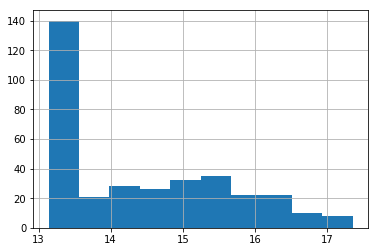

In [8]:
# Peek at the distributions of salary and log_salary.
# Even log_salary has a huge bump on the left.

k_df.log_salary[k_df.year == 2016].hist();

In [9]:
# Due to team changes, some team name values need to be fixed.
# E.g. FLA needs to be changed to MIA.

replacements = {
                "FLA": "MIA",
                "MON": "WSN",
                "ANA": "LAA",
                "TBD": "TBR",
                }

k_df = k_df.replace({'team': replacements})

In [10]:
# There are some pitchers out there with a crazy high ERA.
# Lino Urdaneta for example apparently has an infinite ERA.
# Besides him, there are 10 or so pitchers with ERA > 40.
# I think I will have to establish some kind of minimum limit of innings pitched.

k_df.sort_values('era', ascending=False).head(10)

,age,era,ip,losses,player_name,position,salary,so,so9,team,war,win_loss_perc,wins,year,log_salary
11844,24,inf,0.0,0.0,Lino Urdaneta,Pitcher,300000.0,0.0,NaN,DET,NaN,NaN,0.0,2004,12.611538
9442,25,108.000000,0.1,0.0,David Carpenter,Pitcher,493000.0,1.0,27.0,LAA,-0.4,NaN,0.0,2013,13.108264
355,32,81.000000,0.1,1.0,Hipólito Pichardo,Pitcher,500000.0,0.0,0.0,HOU,-0.3,0.0,0.0,2002,13.122363
3217,25,67.500000,1.1,0.0,Radhames Liz,Pitcher,402500.0,1.0,6.8,BAL,-0.5,NaN,0.0,2009,12.905450
2441,31,54.000000,0.1,1.0,Yunesky Maya,Pitcher,2000000.0,0.0,0.0,WSN,-0.3,0.0,0.0,2013,14.508658
6624,32,54.000000,1.0,0.0,Jared Fernandez,Pitcher,325000.0,0.0,0.0,HOU,-0.3,NaN,0.0,2004,12.691580
5464,33,43.200000,1.2,1.0,Juan Guzmán,Pitcher,6000000.0,3.0,16.2,TBR,-0.4,0.0,0.0,2000,15.607270
936,32,42.430000,2.1,0.0,Antonio Osuna,Pitcher,800000.0,0.0,0.0,WSN,-0.5,NaN,0.0,2005,13.592367
7520,24,40.500000,0.2,0.0,Blaine Boyer,Pitcher,336000.0,0.0,0.0,ATL,-0.3,NaN,0.0,2006,12.724866
717,26,37.130000,2.2,0.0,Joe Paterson,Pitcher,487500.0,0.0,0.0,ARI,-0.7,NaN,0.0,2012,13.097046


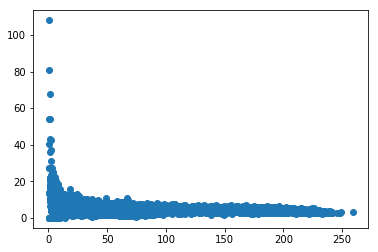

In [11]:
# This plot makes it clear that the crazy ERA values belong to
# pitchers with a small number of innings pitched.
# My guess is that shifting the salary column to create a
# next_year_salary column and dropping the resulting null values
# will eliminate these data points.

plt.scatter(k_df.ip, k_df.era);

In [12]:
# Reset index to prepare for split-apply-combine operation.

k_df = k_df.reset_index(drop=True)

In [13]:
# It looks like there are a couple of pitchers that share the same name.
# Grouping by player_name will not handle these cases well in years that
# they overlap.  The plot below shows the number of play names each year.
# The three spikes show that there are three instances of players with the 
# same name being active in the same year.

#k_df.groupby(['player_name', 'year']).year.count().plot()

In [14]:
# Miguel Alfredo Gonzalez played on the 2014 Phillies.
# Miguel Angel Gonzalez played several season on other teams.
# A player named Roberto Hernandez who went by Fausto Carmona played for the 2007 Cleveland Indians.
# Another player Roberto Hernandez played for a couple of different teams that year.
# Apparently, two people named Christopher John Carpenter were both major league pitchers in 2012.
# The one that played two seasons (2011 CHC and 2012 BOS) I've decided to call Chris Carpenter 1
# The other one is Chris Carpenter 2.

# Can't figure out how to fix these guys since they span multiple teams.

In [15]:
# Group by player, and create next_year_salary column with a shift.

k_df[['next_year_salary', 'next_year_log_salary']] = k_df.groupby('player_name')[['salary', 'log_salary']].apply(lambda x: x.shift(1))

In [16]:
k_df = k_df.dropna(subset=[['next_year_salary', 'next_year_log_salary']])

In [17]:
# Data is looking clean and ready to start regression.

k_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5039 entries, 1 to 6687
Data columns (total 17 columns):
age                     5039 non-null int64
era                     5006 non-null float64
ip                      5007 non-null float64
losses                  5004 non-null float64
player_name             5039 non-null object
position                5039 non-null object
salary                  5039 non-null float64
so                      5006 non-null float64
so9                     5008 non-null float64
team                    4409 non-null object
war                     5039 non-null float64
win_loss_perc           4783 non-null float64
wins                    4994 non-null float64
year                    5039 non-null int64
log_salary              5039 non-null float64
next_year_salary        5039 non-null float64
next_year_log_salary    5039 non-null float64
dtypes: float64(12), int64(2), object(3)
memory usage: 708.6+ KB


In [18]:
#### Ok, LR model is starting to look decent.  At this point I want to start
#### examining each traditional stat's impact on predicting y and log_y, 
#### controlling for age and year.
#### Also, do cross-validation.
#### Try to do LR with sm and sklearn.

In [20]:
### Cleaned data ready to be pickled.
### Created picklefile 02 Oct in the afternoon.

pickle_filename = '02_oct_cleaned_pickled_pitcher_data.pkl'
with open(pickle_filename, 'wb') as f_obj:
    pickle.dump(k_df, f_obj)